# Build model with XGBOOST

In [1]:
from collections import namedtuple
from datetime import datetime
import time
import warnings

import numpy as np
import pandas as pd
from sklearn import feature_selection
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
import xgboost as xgb

from src.plots import plot_feature_importances

label_names = ["non-smoker", "smoker"] # 0 = non-smoker and 1 = smoker
random_state = 111

Load normalized training/test data from the preprocessing step

In [2]:
X_train_df = pd.read_csv("output/train_data_normalized.csv")
X_test_df = pd.read_csv("output/test_data_normalized.csv")
y_train_df = pd.read_csv("output/train_labels.csv")
y_test_df = pd.read_csv("output/test_labels.csv")
features = X_train_df.columns

X_train = X_train_df.to_numpy()
X_test = X_test_df.to_numpy()
y_train = y_train_df.to_numpy().ravel()
y_test = y_test_df.to_numpy().ravel()

In [3]:
X_train_df.head()

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,...,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries
0,0.538462,0.363636,0.190476,0.307692,0.071429,0.091837,0.0,0.0,0.141975,0.141509,...,0.033300,0.124260,0.079075,0.49375,0.0,0.060870,0.014760,0.003776,0.008024,0.0
1,0.461538,0.454545,0.380952,0.512821,0.112245,0.010204,0.0,0.0,0.302469,0.377358,...,0.085772,0.091716,0.090909,0.73125,0.0,0.086957,0.027675,0.009955,0.038114,0.0
2,0.230769,0.545455,0.428571,0.551282,0.142857,0.091837,0.0,0.0,0.364198,0.358491,...,0.235116,0.035503,0.051103,0.56875,0.0,0.069565,0.015683,0.006866,0.061184,0.0
3,0.307692,0.636364,0.380952,0.435897,0.112245,0.142857,0.0,0.0,0.290123,0.358491,...,0.175580,0.136095,0.076385,0.65625,0.0,0.095652,0.011993,0.004119,0.016048,0.0
4,0.307692,0.545455,0.380952,0.461538,0.142857,0.112245,0.0,0.0,0.364198,0.377358,...,0.114026,0.121302,0.074771,0.63750,0.0,0.069565,0.011070,0.004806,0.028084,0.0


## Build starter model with no parameter tuning

In [4]:
starter_model = xgb.XGBClassifier(use_label_encoder=False, random_state=random_state)
starter_model.fit(X_train, y_train)
starter_model_preds = starter_model.predict(X_test)
print(f"Training: {starter_model.score(X_train, y_train)}, Testing: {starter_model.score(X_test, y_test)}\n")
print(classification_report(y_test, starter_model_preds, target_names=label_names))

Training: 0.873344662840286, Testing: 0.7746569193279467

              precision    recall  f1-score   support

  non-smoker       0.83      0.82      0.82      4960
      smoker       0.69      0.70      0.69      2837

    accuracy                           0.77      7797
   macro avg       0.76      0.76      0.76      7797
weighted avg       0.78      0.77      0.77      7797



Right away we are outperforming our baseline model - with a testing score of 77% and we are within an acceptable range between training and test regarding overfitting although we are right on the line.

Let's look at feature importance

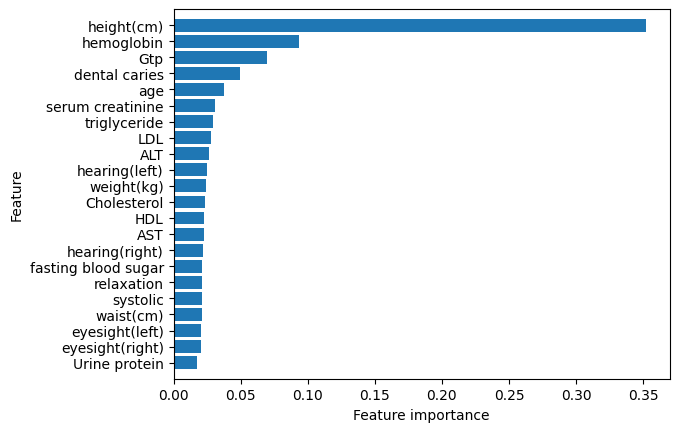

In [5]:
plot_feature_importances(starter_model, len(X_train_df.columns), X_train_df.columns)

Height doesn't make a ton of sense to have as the highest feature importance. It doesn't really even make sense to have in our dataset - in reality it wouldn't help us accurately diagnose smokers.

Let's remove it and run the model again

In [6]:
X_train_drop_height_df = X_train_df.drop(["height(cm)"], axis=1)
X_test_drop_height_df = X_test_df.drop(["height(cm)"], axis=1)

X_train_drop_height = X_train_drop_height_df.to_numpy()
X_test_drop_height = X_test_drop_height_df.to_numpy()

In [7]:
starter_model = xgb.XGBClassifier(use_label_encoder=False, random_state=random_state)
starter_model.fit(X_train_drop_height, y_train)
starter_model_preds = starter_model.predict(X_test_drop_height)
print(f"Training: {starter_model.score(X_train_drop_height, y_train)}, Testing: {starter_model.score(X_test_drop_height, y_test)}\n")
print(classification_report(y_test, starter_model_preds, target_names=label_names))

Training: 0.8728957578478213, Testing: 0.7668333974605618

              precision    recall  f1-score   support

  non-smoker       0.81      0.82      0.82      4960
      smoker       0.68      0.67      0.68      2837

    accuracy                           0.77      7797
   macro avg       0.75      0.75      0.75      7797
weighted avg       0.77      0.77      0.77      7797



Our scores went down a little bit - but I believe this will lead to a better model in production

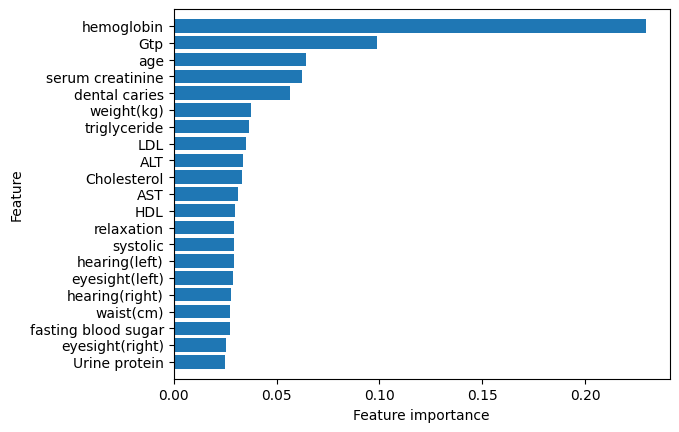

In [8]:
plot_feature_importances(starter_model, len(X_train_drop_height_df.columns), X_train_drop_height_df.columns)

Let's see if we can either get a better fit or better testing score based on tuning the model.

## Build model with parameter tuning

We will be using a range of parameters to try to manage overfitting while finding a good score. We want our model to generalize to real world datasets.

We are using cross validation, early stopping, roc auc for scoring, max depth - this should help us manage overfitting.

We will be using GridSearchCV to help with testing different parameters to help us find the best parameters

In [9]:
# determines the number of jobs to run in parallel. -2 will use all but one of your cores. -1 will use all of them.
n_jobs=-2

param_grid = {
    "n_estimators": [500, 750, 1000],
    "max_depth": [5], # 6 is default, higher typically leads to overfitting
    "learning_rate": [0.1, 0.05, 0.3], # 0.3 is default
    "reg_alpha": [0], # l1 regularization, scores > 0, 0 = no regularization
    "reg_lambda": [0, 1, 2], # l2 regularization scores > 0, 0 = no regularization
    "gamma": [0, 1, 10, 100],
    "min_child_weight": [1, 2], # higher values will lead to less overfitting, 1 is default
    "subsample": [0.8, 0.9], # default is 1
    "colsample_bytree": [0.8, 0.9] # default is 1
}

In [10]:
eval_set = [(X_test_drop_height, y_test)]

# ignore the stopped worker warning - this doesn't have any impact on the result of the model and will differ from computer to computer
with warnings.catch_warnings():
    warnings.filterwarnings(
        "ignore", 
        message="A worker stopped while some jobs were given to the executor.*",
        category=UserWarning
    )

    start_time = time.time()
    print(f'Start time: {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}')
    grid_search = GridSearchCV(
        estimator=xgb.XGBClassifier(use_label_encoder=False, random_state=random_state), 
        param_grid=param_grid, 
        cv=5, 
        n_jobs=n_jobs, 
        verbose=1, 
        scoring="roc_auc"
    )
    grid_search.fit(X_train_drop_height, y_train)

    model = xgb.XGBClassifier(
        **grid_search.best_params_,
        use_label_encoder=False,
        random_state=random_state,
        early_stopping_rounds=10,
    )

    model.fit(
        X_train_drop_height, 
        y_train,
        eval_set=eval_set,
        verbose=0
    )

    model_preds = model.predict(X_test_drop_height)

    print(f"Grid search completed in {time.time() - start_time} seconds\n")
    print(f"\nTraining: {model.score(X_train_drop_height, y_train)}, Testing: {model.score(X_test_drop_height, y_test)}\n")
    print(classification_report(y_test, model_preds, target_names=label_names))

Start time: 2024-03-12 09:17:00
Fitting 5 folds for each of 864 candidates, totalling 4320 fits
Grid search completed in 330.7535490989685 seconds


Training: 0.8353480616923719, Testing: 0.7659356162626652

              precision    recall  f1-score   support

  non-smoker       0.81      0.82      0.82      4960
      smoker       0.68      0.66      0.67      2837

    accuracy                           0.77      7797
   macro avg       0.75      0.74      0.75      7797
weighted avg       0.76      0.77      0.77      7797



In [11]:
print(f"\nBest parameters: {grid_search.best_params_}\n")


Best parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 1000, 'reg_alpha': 0, 'reg_lambda': 0, 'subsample': 0.9}



Our overall testing score went down slightly but we have a better fit model.

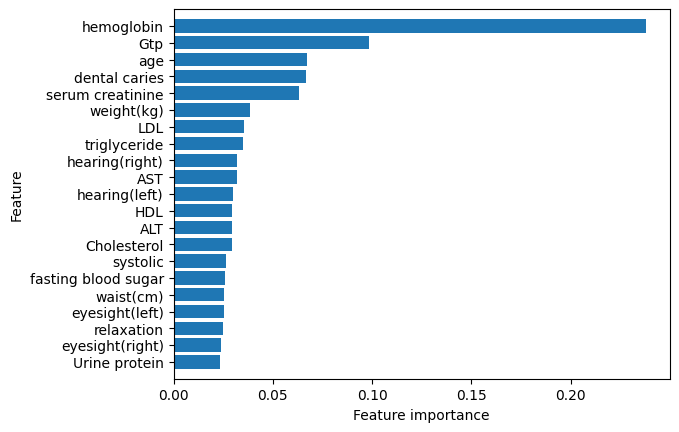

In [13]:
plot_feature_importances(model, len(X_train_drop_height_df.columns), X_train_drop_height_df.columns)

Let's see if we can get any additonal accuracy with feature selection

## Build model with parameter tuning + feature selection

The function below will iterate through percentages of parameters to keep. It will capture the ROC AUC score and testing score for each iteration. We will keep the highest testing score

In [14]:
FeatureSelectionResult = namedtuple("FeatureSelectionResult", ["optimal_percent", "test_score", "roc_auc_cv_score", "selected_features"])

def run_feature_selection(clf, X_train, y_train, X_test, y_test, columns: list, cv=5):
    percentiles = range(1, 100, 5)
    roc_auc_scores_dct = {}
    test_scores_dct = {}
    best_test_score = 0
    best_percentile = 0
    best_features = []
    columns_arr = np.array(columns)
    
    for i in percentiles:
        fs = feature_selection.SelectPercentile(feature_selection.f_classif, percentile=i)
        X_train_fs = fs.fit_transform(X_train, y_train)
        X_test_fs = fs.transform(X_test)
        
        kf = KFold(n_splits=cv, shuffle=True, random_state=random_state)
        roc_auc_scores_lst = []
        
        for train_index, val_index in kf.split(X_train_fs):
            X_t, X_val = X_train_fs[train_index], X_train_fs[val_index]
            y_t, y_val = y_train[train_index], y_train[val_index]
            
            eval_set = [(X_val, y_val)]
            clf.fit(X_t, y_t, eval_set=eval_set, verbose=False)
            y_pred_val = clf.predict(X_val)
            roc_auc = roc_auc_score(y_val, y_pred_val)
            roc_auc_scores_lst.append(roc_auc)
        
        clf.fit(X_train_fs, y_train, eval_set=[(X_test_fs, y_test)], verbose=False)
        train_score = clf.score(X_train_fs, y_train)
        test_score = clf.score(X_test_fs, y_test)
        
        roc_auc_scores_dct[i] = np.mean(roc_auc_scores_lst)
        test_scores_dct[i] = test_score
        print(f"Percentage {i}: CV ROC AUC = {np.mean(roc_auc_scores_lst):.3f}, Test Score = {test_score:.3f}, Train score = {train_score:.3f}")

        if test_score > best_test_score:
            best_test_score = test_score
            best_percentile = i
            best_features = columns_arr[fs.get_support(indices=True)]

    return FeatureSelectionResult(optimal_percent=best_percentile, test_score=best_test_score, roc_auc_cv_score=roc_auc_scores_dct[best_percentile], selected_features=list(best_features))

In [15]:
fs_results = run_feature_selection(clf=xgb.XGBClassifier(
    **grid_search.best_params_,
    use_label_encoder=False,
    random_state=random_state,
    early_stopping_rounds=10,
    ), 
    X_train=X_train_drop_height, 
    y_train=y_train, 
    X_test=X_test_drop_height, 
    y_test=y_test,
    columns=X_train_drop_height_df.columns
)

Percentage 1: CV ROC AUC = 0.666, Test Score = 0.690, Train score = 0.686
Percentage 6: CV ROC AUC = 0.661, Test Score = 0.689, Train score = 0.684
Percentage 11: CV ROC AUC = 0.681, Test Score = 0.706, Train score = 0.714
Percentage 16: CV ROC AUC = 0.695, Test Score = 0.725, Train score = 0.733
Percentage 21: CV ROC AUC = 0.699, Test Score = 0.733, Train score = 0.742
Percentage 26: CV ROC AUC = 0.702, Test Score = 0.738, Train score = 0.749
Percentage 31: CV ROC AUC = 0.703, Test Score = 0.739, Train score = 0.771
Percentage 36: CV ROC AUC = 0.713, Test Score = 0.746, Train score = 0.761
Percentage 41: CV ROC AUC = 0.716, Test Score = 0.755, Train score = 0.780
Percentage 46: CV ROC AUC = 0.718, Test Score = 0.750, Train score = 0.767
Percentage 51: CV ROC AUC = 0.721, Test Score = 0.752, Train score = 0.791
Percentage 56: CV ROC AUC = 0.727, Test Score = 0.761, Train score = 0.808
Percentage 61: CV ROC AUC = 0.727, Test Score = 0.762, Train score = 0.802
Percentage 66: CV ROC AUC =

In [16]:
list(set(X_train_drop_height_df.columns) - set(fs_results.selected_features))

['hearing(left)', 'Urine protein', 'hearing(right)']

It looks like we are droping hearing and Urine protein. Hearing makes sense - I can't imagine smoking has an impact on that. We would need to consult with a doctor about Urine protein

In [17]:
print(f"Number of features kept {len(fs_results.selected_features)}")
print(f"% of features kept {fs_results.optimal_percent}")

Number of features kept 18
% of features kept 86


Let's run our model again with our selected features

In [18]:
X_train_selected = X_train_drop_height_df[fs_results.selected_features].to_numpy()
X_test_selected = X_test_drop_height_df[fs_results.selected_features].to_numpy()

eval_set = [(X_test_selected, y_test)]

model = xgb.XGBClassifier(
    **grid_search.best_params_,
    use_label_encoder=False,
    random_state=random_state,
    early_stopping_rounds=10,
)

model.fit(
    X_train_selected, 
    y_train,
    eval_set=eval_set,
    verbose=0
)

model_preds = model.predict(X_test_selected)
print(f"\nTraining: {model.score(X_train_selected, y_train)}, Testing: {model.score(X_test_selected, y_test)}\n")
print(classification_report(y_test, model_preds, target_names=label_names))


Training: 0.8573123416808286, Testing: 0.771707066820572

              precision    recall  f1-score   support

  non-smoker       0.82      0.83      0.82      4960
      smoker       0.69      0.67      0.68      2837

    accuracy                           0.77      7797
   macro avg       0.75      0.75      0.75      7797
weighted avg       0.77      0.77      0.77      7797



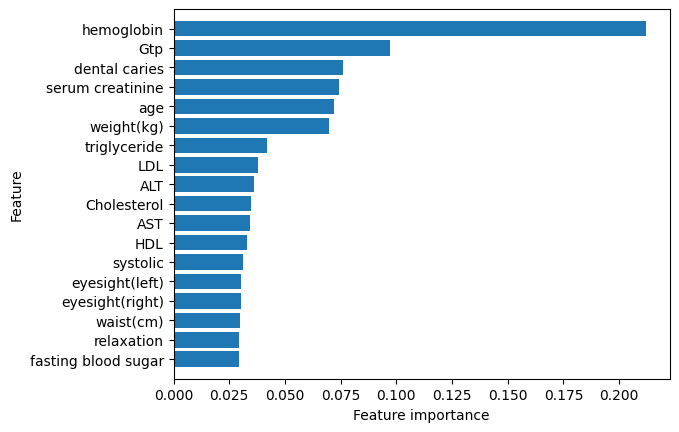

In [19]:
plot_feature_importances(model, len(fs_results.selected_features), fs_results.selected_features)

## Observations and Best Model Specifications/Results
Through parameter tuning and feature selection - we were able to find a model that increased the testing score over our benchmark decision tree model while not overfitting.

In [20]:
print("Model specs:")
print("Params to use with Classifier: ")
print(grid_search.best_params_)
print("Use early stopping rounds of 10 to avoid overfitting")

Model specs:
Params to use with Classifier: 
{'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 1000, 'reg_alpha': 0, 'reg_lambda': 0, 'subsample': 0.9}
Use early stopping rounds of 10 to avoid overfitting


In [22]:
print("\nResults:\n")
print(f"Training: {model.score(X_train_selected, y_train)}, Testing: {model.score(X_test_selected, y_test)}\n")
print(classification_report(y_test, model_preds, target_names=label_names))


Results:

Training: 0.8573123416808286, Testing: 0.771707066820572

              precision    recall  f1-score   support

  non-smoker       0.82      0.83      0.82      4960
      smoker       0.69      0.67      0.68      2837

    accuracy                           0.77      7797
   macro avg       0.75      0.75      0.75      7797
weighted avg       0.77      0.77      0.77      7797

